## Import Libraries & Dataset

In [84]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE, SelectFromModel
from sklearn import metrics
from sklearn.svm import SVC

In [85]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')

##  Data Cleanup & Dummy Variables

In [86]:
#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']
    
# converting TotalCharges object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)

# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values
df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

# Consolidate MultipleLines attribute
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')

# Change all values of 'No internet service' to 'No'
df = df.replace('No internet service','No')

# Replace all yes/no values with 1/0
df = df.replace(to_replace=['Yes','No'], value=[1,0])

# Create dummy variables in the entire dataset
df = pd.get_dummies(df)


## Data Splitting

In [87]:
# Separate the churn results from the dataset
y = df['Churn'].values
x = df.drop(columns = ['Churn'])

# Set features
features = x.columns.values

# Normalize values
scale = MinMaxScaler(feature_range = (0,1))
scale.fit(x)
x = pd.DataFrame(scale.transform(x))
x.columns = features

# Set up train/test split with 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)

## Model Building Approach

Our model building approach is to first run feature selection, iterate multiple models using features selected and then do hypertuning<br>
**1. Feature Selection** using following methods <br>
    1. Removing features using low variance.
    2. Univariate feature selection.
    3. Recursive feature eliminiation.
    4. Select from Model.
**2. Hyper Tuning** using following methods <br>
    1. Weights grid search
    2. Hyperparameter grid search

## Feature Selection

In [88]:
# 1. Removing features using low variance.
def variance_threshold_selector(data, threshold=0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    mask = selector.get_support()
    low_var_features = [] 
    feature_names = list(data.columns.values)
    for bool, feature in zip(mask, feature_names):
        if bool:
            low_var_features.append(feature)
    return low_var_features

# Ran with tresholds of 0,0.1,0.2,0.3,0.4 and looks like threshold of 0.2 gives optimal number of features.
variance_features = variance_threshold_selector(x_train,0.2)
print("Features selected using low variance elimination : \n", variance_features)

Features selected using low variance elimination : 
 ['Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'gender_Female', 'gender_Male', 'InternetService_DSL', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'PaymentMethod_Electronic check']


In [89]:
# 2. Univariate Selection
sel_mutual = SelectKBest(mutual_info_classif, k=8)
x_train_mutual = sel_mutual.fit_transform(x_train, y_train)

mask = sel_mutual.get_support()
univariate_features = [] 
feature_names = list(x_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        univariate_features.append(feature)
print("Features selected using Univariate selection : \n", univariate_features)


Features selected using Univariate selection : 
 ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']


In [121]:
# 3. Recursive Feature Eliminiation

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=10, step=1)
x_train_rfe_logistic = sel_rfe_logistic.fit_transform(x_train, y_train)

mask = sel_rfe_logistic.get_support()
recursive_elim_features = [] 
feature_names = list(x_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        recursive_elim_features.append(feature)
print("Features selected using recursive elimination: \n", recursive_elim_features)


Features selected using recursive elimination: 
 ['tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']


In [117]:
# 4. Feature selection using SelectFromModel
model_logistic = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000, penalty='l1')
sel_model_logistic = SelectFromModel(estimator=model_logistic)
x_train_sfm_l1 = sel_model_logistic.fit_transform(x_train, y_train)

mask = sel_rfe_logistic.get_support()
select_from_features = [] 
feature_names = list(x_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        select_from_features.append(feature)
print("Features selected using select from model method : \n", select_from_features)


Features selected using select from model method : 
 ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']


## Logistic Regression - Model Building

In [108]:
# Model 1 - All Features
model1 = LogisticRegression()
fit2 = model1.fit(x_train,y_train)
predict_model1 = model1.predict(x_test)
print("Model 1 - Accuracy: ",metrics.accuracy_score(y_test,predict_model1))
print("Model 1 - Confusion Matrix: \n", metrics.confusion_matrix(y_test,predict_model1))
print("Model 1 - Classification Report: \n", classification_report(y_test,predict_model1))
weights1 = pd.Series(model1.coef_[0], index=x.columns.values)
print("Model 1 - Weights:\n", weights1.sort_values(ascending = False))


Model 1 - Accuracy:  0.7998580553584103
Model 1 - Confusion Matrix: 
 [[919 104]
 [178 208]]
Model 1 - Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.67      0.54      0.60       386

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Model 1 - Weights:
 TotalCharges                               0.987159
InternetService_Fiber optic                0.822797
Contract_Month-to-month                    0.698867
PaperlessBilling                           0.371334
PaymentMethod_Electronic check             0.292634
MultipleLines                              0.240501
SeniorCitizen                              0.233807
StreamingTV                                0.181166
StreamingMovies                            0.180732
gender_Female                              0.016114
Inter

In [122]:
# Model 2 - Features ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']
model2_features=['tenure', 'MonthlyCharges', 'InternetService_0', 
                 'InternetService_Fiber optic', 'Contract_Month-to-month', 
                 'Contract_Two year', 'PaymentMethod_Electronic check']

x_train_model2=x_train[model2_features]
x_test_model2=x_test[model2_features]

model2 = LogisticRegression()
fit2 = model2.fit(x_train_model2,y_train)
predict_model2 = model2.predict(x_test_model2)
print("Model 2 - Accuracy: ",metrics.accuracy_score(y_test,predict_model2))
print("Model 2 - Confusion Matrix: \n", metrics.confusion_matrix(y_test,predict_model2))
print("Model 2 - Classification Report: \n", classification_report(y_test,predict_model2))
weights2 = pd.Series(model2.coef_[0], index=x_train_model2.columns.values)
print("Model 3 - Weights:\n", weights2.sort_values(ascending = False))



Model 2 - Accuracy:  0.7892122072391767
Model 2 - Confusion Matrix: 
 [[925  98]
 [199 187]]
Model 2 - Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1023
           1       0.66      0.48      0.56       386

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Model 3 - Weights:
 InternetService_Fiber optic       0.988027
Contract_Month-to-month           0.816076
PaymentMethod_Electronic check    0.522160
MonthlyCharges                    0.229578
Contract_Two year                -0.818525
InternetService_0                -0.830917
tenure                           -2.170806
dtype: float64


In [124]:
# Model 3 - Features ['tenure', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year']
model3_features=['tenure', 'MonthlyCharges', 'InternetService_0', 
                 'InternetService_Fiber optic', 'Contract_Month-to-month', 
                 'Contract_Two year']

x_train_model3=x_train[model3_features]
x_test_model3=x_test[model3_features]

model3 = LogisticRegression()
fit3 = model3.fit(x_train_model3,y_train)
predict_model3 = model3.predict(x_test_model3)
print("Model 3 - Accuracy: ",metrics.accuracy_score(y_test,predict_model3))
print("Model 3 - Confusion Matrix: \n", metrics.confusion_matrix(y_test,predict_model3))
print("Model 3 - Classification Report: \n", classification_report(y_test,predict_model3))
weights3 = pd.Series(model3.coef_[0], index=x_train_model3.columns.values)
print("Model 3 - Weights:\n", weights3.sort_values(ascending = False))

Model 3 - Accuracy:  0.7785663591199432
Model 3 - Confusion Matrix: 
 [[918 105]
 [207 179]]
Model 3 - Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.85      1023
           1       0.63      0.46      0.53       386

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

Model 3 - Weights:
 InternetService_Fiber optic    1.068643
Contract_Month-to-month        0.886151
MonthlyCharges                 0.298494
Contract_Two year             -0.863665
InternetService_0             -0.937093
tenure                        -2.264741
dtype: float64


In [143]:
# Model 4 - Features ['tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', 'InternetService_0', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'PaymentMethod_Electronic check']
model4_features=['tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 
                  'InternetService_0', 'InternetService_Fiber optic', 
                 'Contract_Month-to-month', 'PaymentMethod_Electronic check']
x_train_model4=x_train[model4_features]
x_test_model4=x_test[model4_features]

model4 = LogisticRegression()
fit4 = model4.fit(x_train_model4,y_train)
predict_model4 = model4.predict(x_test_model4)
print("Model 4 - Accuracy: ",metrics.accuracy_score(y_test,predict_model4))
print("Model 4 - Confusion Matrix: \n", metrics.confusion_matrix(y_test,predict_model4))
print("Model 4 - Classification Report: \n", classification_report(y_test,predict_model4))
weights4 = pd.Series(model4.coef_[0], index=x_train_model4.columns.values)
print("Model 4 - Weights:\n", weights4.sort_values(ascending = False))

Model 4 - Accuracy:  0.8026969481902059
Model 4 - Confusion Matrix: 
 [[928  95]
 [183 203]]
Model 4 - Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1023
           1       0.68      0.53      0.59       386

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Model 4 - Weights:
 InternetService_Fiber optic       1.468734
Contract_Month-to-month           1.048091
PaymentMethod_Electronic check    0.481241
StreamingMovies                   0.408612
StreamingTV                       0.386843
InternetService_0                -1.174945
MonthlyCharges                   -1.487988
tenure                           -2.298676
dtype: float64


Immediate thoughts on the weights, TotalCharges makes sense. Seeing the month-to-month up there is not surprising and supports our initial EDA findings. Tenure being the least likely to churn also lines up with our EDA findings, most people were likely to churn within the first few months.

In [9]:
from sklearn.preprocessing import StandardScaler

# We want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std as this would be snooping.
# To make things easier, let's start by just using whatever was last stored in the variables:
# X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(x_train) 

x_train_scaled = scl_obj.transform(x_train
x_test_scaled = scl_obj.transform(x_test) 

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 
lr_clf.fit(x_train_scaled,y_train) 

y_hat = lr_clf.predict(x_test_scaled) 

acc = metrics.accuracy_score(y_test,y_hat)
conf = metrics.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) 
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

accuracy: 0.7970191625266146
[[917 106]
 [180 206]]
tenure has weight of -0.7827311937436287
gender_Male has weight of -0.3207009561061886
Contract_One year has weight of -0.28773904658151933
OnlineSecurity has weight of -0.1958241896445195
TechSupport has weight of -0.14652320642901628
PhoneService has weight of -0.13398740382900123
Contract_Two year has weight of -0.0721570158953758
OnlineBackup has weight of -0.07200490850248978
Dependents has weight of -0.0599453719782199
PaymentMethod_Bank transfer (automatic) has weight of -0.05805321342249359
Contract_Month-to-month has weight of -0.045545701800098155
InternetService_0 has weight of -0.03962071304805837
Partner has weight of -0.030930329684591553
DeviceProtection has weight of -0.020756366654214986
PaymentMethod_Electronic check has weight of -0.017051146972407984
gender_Female has weight of -0.007851641497604044
Churn has weight of 0.007851641497605404
StreamingMovies has weight of 0.06950857432974115
StreamingTV has weight of 

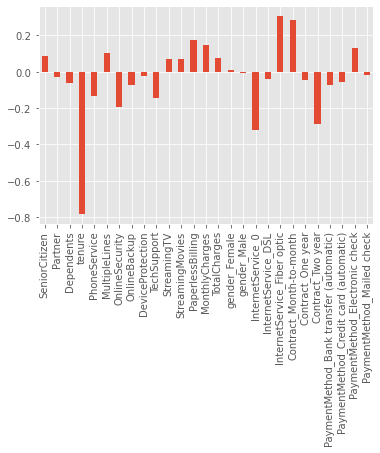

In [10]:
# Now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=x.columns.values)
weights.plot(kind='bar')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


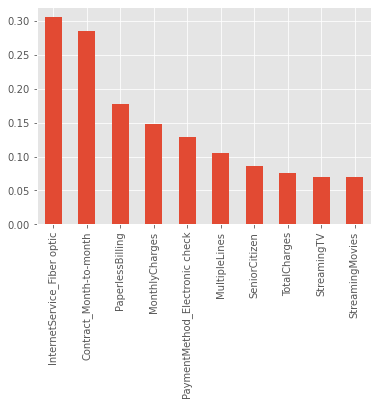

In [11]:
# To get the weights of all the variables
weights = pd.Series(lr_clf.coef_[0],
                 index=x.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


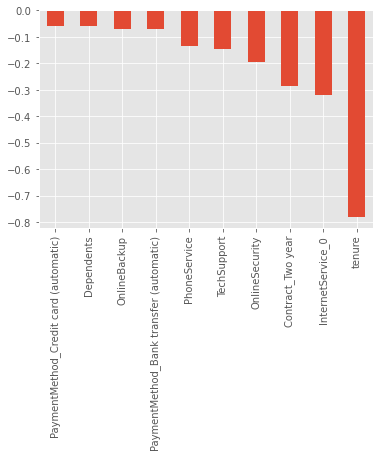

In [12]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

## Observations
We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

As we saw in our EDA, having a monthly contract reduces chances of churn. monthly contract along with tenure have the most negative relation with Churn as predicted by logistic regressions Having DSL internet service also reduces the proability of Churn Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening. Any hypothesis on the above would be really helpful!

## Support Vectors

In [14]:
# Fit and predict using SVM
# Support Vectors are the data points that are closest to the edges of the margin of the separating line.
# The separating line and margins are called the hyperplane
svm = SVC(kernel='rbf',cache_size=1000)
svm.fit(x_train,y_train)
predict = svm.predict(x_test)
print("Our accuracy score of the model using SVM is: ",metrics.accuracy_score(y_test,predict))
print("This is about the same as our logistic regression model")

Our accuracy score of the model using SVM is:  0.7955997161107168
This is about the same as our logistic regression model


In [8]:
# Confusion matrix
print(confusion_matrix(y_test,predict))

[[919 104]
 [178 208]]


## Observations
With SVM we get accuracy of up to 79%